In [1]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde as kde
import torch as pt
from itertools import product
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#pt.set_default_tensor_type('torch.FloatTensor')
pt.set_default_tensor_type('torch.cuda.FloatTensor')

In [2]:
dataset = pd.read_csv(
    'data_files/kc_house_data.csv',
    index_col = 'id', parse_dates = ['date'], date_parser = lambda x: pd.datetime.strptime(x, '%Y%m%dT%H%M%S')
)
dataset = dataset[[col for col in dataset.columns if not col.endswith('15')]]
feature_cols = ['sqft_living', 'bedrooms', 'bathrooms']
target_cols = ['price']
dataset[target_cols] = np.log(dataset[target_cols])

In [3]:
alpha = 0.1
beta = 0.001
clamp = 1e-16
grad_smooth = 0
grad_sq_smooth = 0
learn_rate = 1e-2

feature_tensor = pt.from_numpy(dataset[feature_cols].values).type(pt.Tensor)
target_tensor = pt.from_numpy(dataset[target_cols].values).type(pt.Tensor)
coefs = pt.zeros(len(feature_cols) + 1, len(target_cols))

In [ ]:
t = tqdm.tnrange(10000)
loss_rcd = []
for i in t:
    coefs.requires_grad = True
    predict_tensor = (feature_tensor @ coefs[1:, :]) + coefs[0, :]
    error = (target_tensor - predict_tensor) ** 2
    loss = pt.sqrt(error.mean(dim = 0)).sum()
    
    loss_rcd.append(loss.detach().cpu().numpy())
    t.set_postfix({'loss': loss_rcd[-1]})
    
    grad = pt.autograd.grad(loss, coefs)[0]
    with pt.no_grad():
        grad_smooth = (alpha * grad) + ((1 - alpha) * grad_smooth)
        grad_sq_smooth = (beta * (grad ** 2)) + ((1 - beta) * grad_sq_smooth)

        alpha_scaler = 1 - (alpha ** (i+1))
        beta_scaler = 1 - (beta ** (i+1))
        
        learn_step = (
            grad_smooth / alpha_scaler
        ) / pt.clamp(
            pt.sqrt(grad_sq_smooth / beta_scaler),
        clamp, np.inf)
        
        coefs = coefs - (learn_step * (learn_rate / grad.size()[0]))

In [29]:
t1 = tqdm.tqdm_notebook(list(product(*[(False, True)] * len(feature_cols))))
loss_record = []
for col_shuffle in t1:
    iter_losses = []
    t2 = tqdm.tnrange(100, leave = False)
    for i in t2:
        shuffle_tensor = []
        for col_idx in range(len(feature_cols)):
            if col_shuffle[col_idx]:
                shuffle_tensor.append(feature_tensor[pt.randperm(feature_tensor.size()[0]),col_idx])
            else:
                shuffle_tensor.append(feature_tensor[:,col_idx])
        shuffle_tensor = pt.stack(shuffle_tensor, dim = 1)
        
        predict_tensor = (shuffle_tensor @ coefs[1:,:]) + coefs[0,:]
        error = (target_tensor - predict_tensor) ** 2
        loss = pt.sqrt(error.mean())
        iter_losses.append(loss.detach().cpu().numpy())
    iter_losses = np.stack(iter_losses)
    loss_record.append((col_shuffle, iter_losses))

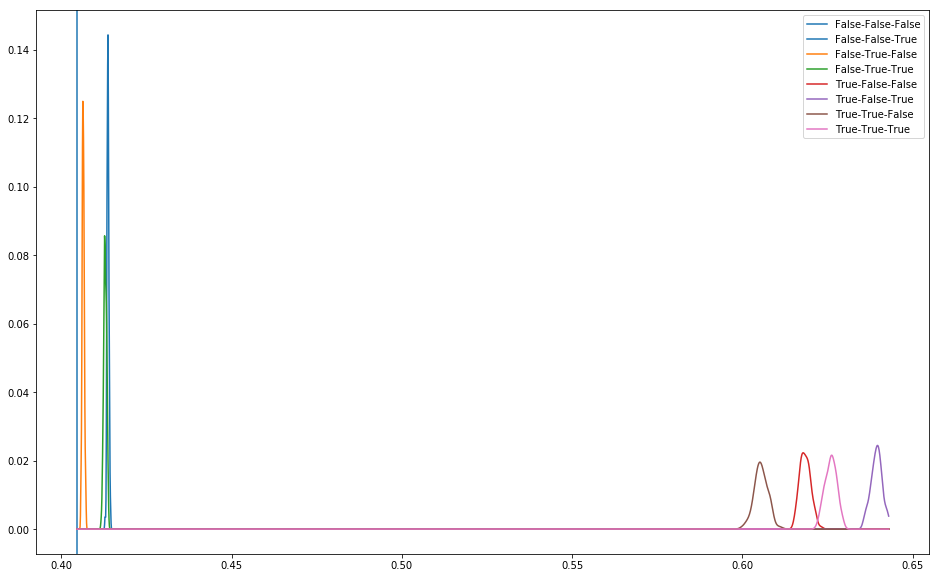

In [30]:
step = 1e-4
x = np.arange(np.stack([loss[1] for loss in loss_record]).min(), np.stack([loss[1] for loss in loss_record]).max()+step, step)
plt.figure(figsize=(16,10))
for loss_cat, losses in loss_record:
    if np.stack(loss_cat).sum() == 0:
        plt.axvline(losses[0], label = '%s-%s-%s' % loss_cat)
    else:
        y = kde(losses).pdf(x)
        y /= y.sum()
        plt.plot(x, y, label = '%s-%s-%s' % loss_cat)
plt.legend()

In [31]:
[(loss[0], loss[1].mean(), loss[1].std()) for loss in loss_record]

[((False, False, False), 0.4045873, 0.0),
 ((False, False, True), 0.41367686, 0.00027050177),
 ((False, True, False), 0.40640882, 0.00030053646),
 ((False, True, True), 0.41286156, 0.00042571887),
 ((True, False, False), 0.6184751, 0.0015581368),
 ((True, False, True), 0.6394327, 0.0016159366),
 ((True, True, False), 0.60551846, 0.0019864773),
 ((True, True, True), 0.62599623, 0.001672248)]